# Model Building

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Reading the data

In [3]:
heart_df = pd.read_csv('/content/drive/MyDrive/Fusemachines Heart Disease/heart.csv')

In [4]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Exploring categorical and Numerical Features

In [6]:
cat_attribs = heart_df.select_dtypes(['object']).columns.to_list()
num_attribs = [col for col in heart_df.columns.to_list() if col not in cat_attribs]
to_impute_attribs = ["Cholesterol", "Oldpeak"]
for _ in to_impute_attribs:
  num_attribs.remove(_)
num_attribs = to_impute_attribs + num_attribs

num_attribs.remove("HeartDisease")

num_attribs.remove('FastingBS')
cat_attribs.append('FastingBS')

## Special Attributes
cat_attribs = cat_attribs + ['Zero_Cholesterol', 'Zero_RestingBP']


print("Categorical: ", cat_attribs)
print("Numberical: ", num_attribs)

Categorical:  ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'Zero_Cholesterol', 'Zero_RestingBP']
Numberical:  ['Cholesterol', 'Oldpeak', 'Age', 'RestingBP', 'MaxHR']


## Defining data transformation

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
class Zero_to_NAN_Converter(BaseEstimator, TransformerMixin):
    def __init__(self, cols=-1):
      self.cols = cols

    def fit(self, X, y=None):
      return self

    def transform(self, X, y=None):
      good_data = X[:, self.cols+1:]
      for i in range(self.cols, -1, -1):
        good_data = np.c_[np.where(X[:, i] == 0, np.nan, X[:, i]), good_data]
        print(good_data.shape)
      return good_data


## Building pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer


num_pipeline = Pipeline([
  ('knn_imputer', KNNImputer(n_neighbors=4)),
  ('std_scaler', RobustScaler()),
])

cat_pipeline = Pipeline([
  ("one_hot", OneHotEncoder(sparse=False))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

## Spiliting the data and applying Transformations

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(heart_df.drop('HeartDisease', axis=1), heart_df['HeartDisease'], test_size=0.25, random_state=42)

X_train['Zero_Cholesterol'] = X_train['Cholesterol'] == 0
X_train['Zero_RestingBP'] = X_train['RestingBP'] == 0
X_test['Zero_Cholesterol'] = X_test['Cholesterol'] == 0
X_test['Zero_RestingBP'] = X_test['RestingBP'] == 0

X_train['Cholesterol']=X_train['Cholesterol'].replace(0,np.nan)
X_train['RestingBP']=X_train['RestingBP'].replace(0,np.nan)
X_test['Cholesterol']=X_test['Cholesterol'].replace(0,np.nan)
X_test['RestingBP']=X_test['RestingBP'].replace(0,np.nan)


X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


linear_clf = LogisticRegression(C=0.1, solver='liblinear')
forest_clf = RandomForestClassifier(random_state=42, criterion='entropy', max_features=6, n_estimators=200)
neighbour_clf = KNeighborsClassifier()
gb_clf = GradientBoostingClassifier(loss='exponential', subsample=0.6, n_estimators=50)
lgbm_clf = LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
cat_clf = CatBoostClassifier()
svc_clf = SVC(gamma="auto", C=1, degree=3, kernel='linear', probability=True)

voting_clf = VotingClassifier(
estimators=[('lr', linear_clf), ('rf', forest_clf),
            ('svc', svc_clf), ('knn', neighbour_clf),
            ('gb', gb_clf)],
    voting='soft')
models = [
          ("Logistic", linear_clf),
          ("Forest", forest_clf),
          ("KN", neighbour_clf),
          ("GB", gb_clf),
          ("LGBM" , lgbm_clf),
          # ("Cat", CatBoostClassifier()),
          ("SVC", svc_clf),
          ("Soft", voting_clf),
]
cv = 10


def score_models(models, X_train, y_train, cv=10):
  scores = []
  for model_name, model in models:
    score = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"{model_name}: {np.median(score)}")
    scores.append((model_name, score))
  return scores

scores = score_models(models, X_train, y_train)

Logistic: 0.8676470588235294
Forest: 0.8759590792838874
KN: 0.8759590792838874
GB: 0.855072463768116
[LightGBM] [Info] Number of positive: 338, number of negative: 281
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 619, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546042 -> initscore=0.184691
[LightGBM] [Info] Start training from score 0.184691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

## Plotting the accuracy

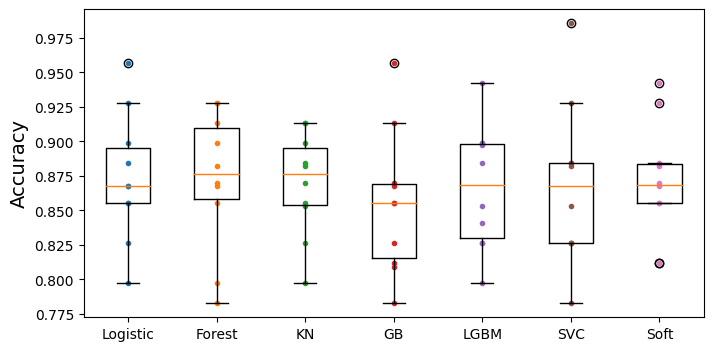

In [11]:
import matplotlib.pyplot as plt

def plot_scores(scores):
  plt.figure(figsize=(8, 4))
  i = 1
  for model_name, score in scores:
    plt.plot([i]*cv, score, ".")
    i += 1

  plt.boxplot([score for _, score in scores],
              labels=[model_name for model_name, _ in scores])
  plt.ylabel("Accuracy", fontsize=14)
  plt.show()

plot_scores(scores)

## Choosing Linear Model

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def final_eval_model(model):
  global X_test, y_test
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))



##GridSearchCV

In [13]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid=[
            {'poly__degree': [2, 3, 4, 5],
             'linear__C': [0.1, 0.5, 1, 5, 10],
             'linear__penalty': ['none', 'l2'],
             'linear__solver': ['newton-cg', 'lbfgs', 'sag']},
		        {'linear__C': [0.1, 0.5, 1, 5, 10],
             'linear__penalty': ['l1', 'l2'],
		         'linear__solver': ['liblinear'],
             'poly__degree': [2, 3, 4, 5]
             }
            ]
# distribution = [{'loss': ['log_loss', 'exponential'],
# 		                          'learning_rate': range(0.05, 0.15, 0.01),
# 		                          'n_estimators': range(40, 100, 10),
#                               'subsample': range(0.5, 1, 0.1),
#                               'criterion': ['friedman_mse', 'squared_error']}]

from sklearn.preprocessing import PolynomialFeatures
clf = Pipeline([
                ('poly', PolynomialFeatures(5)),
                ('scalar', StandardScaler()),
                ('linear', LogisticRegression(penalty='l2', solver='sag', C=0.1, max_iter=200))
])

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True)
grid_search = clf
# grid_search = RandomizedSearchCV(clf, distribution, n_iter=30, scoring='accurary')

In [14]:
grid_search = grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
final_eval_model(grid_search)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        98
           1       0.93      0.87      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



In [16]:
import joblib
joblib.dump(grid_search, 'model.pkl', compress = 1)
joblib.dump(full_pipeline, 'pipeline.pkl', compress = 1)


['pipeline.pkl']

## RandomizedSearchCV

In [17]:
lg = RandomizedSearchCV(lgbm_clf,{
       'max_depth':range(3,12),
       'num_leaves': range(50,200),#sets numbeer of nodes per tree
       'num_estimators':[200,400,600,800,1000,1400],#number of trees
       'learning_rate':[0.01,0.02,0.03,0.04],
       'max_bin':range(100,300),#controls the maximum number of bins that features will bucketed into.reduce to reduce training time
       'min_gain_to_split':range(3,15),
       'lambda_l1': [0,1,3,5],
       'lambda_l2': [0,1,3,5]#specifies L1 or L2 regularization
      },               cv = cv,
                       verbose = 2,
                       random_state = 42,
                       return_train_score = False,
                       n_jobs = -1,
                       n_iter = 200)
lg.fit(X_train,y_train)
print("The best hyperparameters :")
print(lg.best_params_)
print("")
print("The best score:")
print(lg.best_score_)


Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 376, number of negative: 312
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can s

## Voting Classifier

In [18]:
voting_clf = VotingClassifier(
estimators=[('lr', linear_clf), ('rf', forest_clf),
            ('svc', svc_clf), ('knn', neighbour_clf),
            ('gb', gb_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=6,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=1, gamma='auto', kernel='linear',
                                  probability=True)),
                             ('knn', KNeighborsClassifier()),
                             ('gb',
                              GradientBoostingClassifier(loss='exponential',
                                                         n_estimators=50,
                                                         subsample=0.6))],
                 voting='soft')

In [22]:
y_pred = voting_clf.predict_proba(X_test)[:, 1] > 0.2

In [23]:
import joblib
print(classification_report(y_test, y_pred))
joblib.dump(voting_clf, 'model.pkl', compress = 1)
joblib.dump(full_pipeline, 'pipeline.pkl', compress = 1)

              precision    recall  f1-score   support

           0       0.92      0.72      0.81        98
           1       0.82      0.95      0.88       132

    accuracy                           0.86       230
   macro avg       0.87      0.84      0.85       230
weighted avg       0.87      0.86      0.85       230



['pipeline.pkl']

In [24]:
voting_clf.predict(X_test)

joblib.dump(voting_clf, 'model.pkl', compress = 1)

['model.pkl']

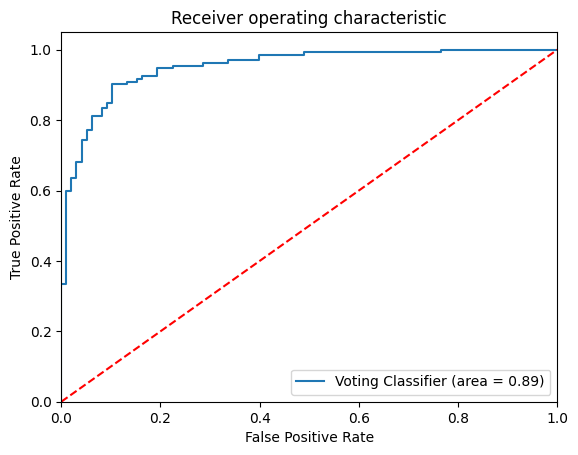

In [25]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
voting_clf_roc_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % voting_clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()